In [1]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
import tensorflow as tf
import time
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from pandas_profiling import ProfileReport
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('https://datahack-prod.s3.amazonaws.com/train_file/train_ctrUa4K.csv')
df_test = pd.read_csv('https://datahack-prod.s3.amazonaws.com/test_file/test_lAUu6dG.csv')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


# Cleaned Dataset with Imputation

In [3]:
df['Credit_History'].fillna(0,inplace=True)
df['Self_Employed'].fillna('No',inplace=True)
df['Dependents'].fillna('0',inplace=True)
df['Gender'].fillna('Male',inplace=True)
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].median(),inplace=True)
df = df.dropna()
df.loc[df.Loan_Status == 'Y','Loan_Status'] = 1
df.loc[df.Loan_Status == 'N','Loan_Status'] = 0
le = LabelEncoder()
df[['Gender','Self_Employed','Married','Credit_History','Education','Dependents']] = df[['Gender','Self_Employed','Married','Credit_History','Education','Dependents']].apply(LabelEncoder().fit_transform)
transformer = make_column_transformer(
    (OneHotEncoder(), ['Property_Area']),
    remainder='passthrough')
transformed = transformer.fit_transform(df)
df = pd.DataFrame(
    transformed, 
    columns=['Rural','Semiurban','Urban','Loan_ID','Gender','Married','Dependents','Education','Self_Employed','ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','Credit_History','Loan_Status']
)
Scaler = StandardScaler()
df[['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term']] = Scaler.fit_transform(df[['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term']])
df.loc[df.Dependents == '3+','Dependents'] = 3
df[['Rural','Semiurban','Urban','Gender','Married','Dependents','Education','Self_Employed','Credit_History','Loan_Status']]= df[['Rural','Semiurban','Urban','Gender','Married','Dependents','Education','Self_Employed','Credit_History','Loan_Status']].apply(pd.to_numeric, errors='coerce')
df_cleaned = df
df_cleaned.to_csv('./Cleaned_Data/Loan_cleaned_filled.csv')

# Cleaned Dataset with Dropped NAs

In [6]:

df['Salary'] = df['Salary'].fillna(df['Salary'].median())
df = df.dropna()
df.loc[df.Loan_Status == 'Y','Loan_Status'] = 1
df.loc[df.Loan_Status == 'N','Loan_Status'] = 0
le = LabelEncoder()
df[['Gender','Self_Employed','Married','Credit_History','Education','Dependents']] = df[['Gender','Self_Employed','Married','Credit_History','Education','Dependents']].apply(LabelEncoder().fit_transform)
transformer = make_column_transformer(
    (OneHotEncoder(), ['Property_Area']),
    remainder='passthrough')
transformed = transformer.fit_transform(df)
df = pd.DataFrame(
    transformed, 
    columns=['Rural','Semiurban','Urban','Loan_ID','Gender','Married','Dependents','Education','Self_Employed','ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','Credit_History','Loan_Status']
)
Scaler = StandardScaler()
df[['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term']] = Scaler.fit_transform(df[['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term']])
df.loc[df.Dependents == '3+','Dependents'] = 3
df[['Rural','Semiurban','Urban','Gender','Married','Dependents','Education','Self_Employed','Credit_History','Loan_Status']]= df[['Rural','Semiurban','Urban','Gender','Married','Dependents','Education','Self_Employed','Credit_History','Loan_Status']].apply(pd.to_numeric, errors='coerce')
df_cleaned = df
df_cleaned.to_csv('./Cleaned_Data/Loan_cleaned.csv')

In [4]:
df_cleaned = pd.read_csv('./Cleaned_Data/Loan_cleaned_filled.csv')
df_train = df_cleaned
df_train.drop('Loan_ID', axis=1, inplace=True)
df_train
X = df_train.drop('Loan_Status', axis = 1)
df_train
y = df_train['Loan_Status']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, train_size = 0.8, random_state=30)

In [ ]:
model = Sequential()
model.add(Dense(32, input_dim=X.shape[1], kernel_initializer='uniform',activation="relu" ))
model.add(Dense(32,activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(32,activation="relu"))
model.add(Dropout(0.35))
model.add(Dense(units = 1, activation='sigmoid', kernel_initializer='uniform'))
model.compile( metrics = [tf.keras.metrics.BinaryAccuracy()],loss = 'binary_crossentropy' )

In [ ]:
skf = StratifiedKFold(n_splits=5)
for i,(train_index, test_index) in enumerate(skf.split(X, y)):
    
    start_time = time.time()
    print('Running Fold: '+ str(i+1))
    model.fit(X.iloc[train_index], y.iloc[train_index], verbose=0, epochs=350, batch_size=32, )
    y_pred = model.predict(X.iloc[test_index])
    rounded = y_pred>0.5
    print("Accuracy:",metrics.accuracy_score(y.iloc[test_index], rounded))
    print("Precision:",metrics.precision_score(y.iloc[test_index], rounded))
    print("Recall:",metrics.recall_score(y.iloc[test_index], rounded))
    model.save('./ML_Model/loan_nn_'+str(round(metrics.accuracy_score(y.iloc[test_index], rounded),ndigits=2))+'_'+str(round(metrics.f1_score(y.iloc[test_index], rounded),ndigits=2))+'_'+time.strftime('%H-%M-%S'))
    print("Training Time: " + str(round((time.time() - start_time),ndigits=2)))

# Evaluate Performance

In [54]:
y_pred = model.predict(X_test)
rounded = y_pred>0.6
#rounded = np.round(y_pred)

print("Accuracy:",metrics.accuracy_score(y_test, rounded))
print("Precision:",metrics.precision_score(y_test, rounded))
print("Recall:",metrics.recall_score(y_test, rounded))

4/4 [==============================] - 0s 3ms/step
Accuracy: 0.8220338983050848
Precision: 0.8351648351648352
Recall: 0.926829268292683


[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

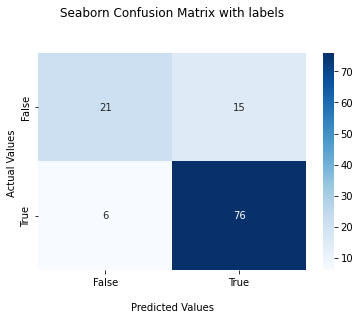

In [5]:
cf_matrix = confusion_matrix(y.iloc[test_index], rounded)
cf_matrix

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

# Cleaned Test Dataset

In [103]:
df_test = pd.read_csv('https://datahack-prod.s3.amazonaws.com/test_file/test_lAUu6dG.csv')
df = df_test

In [104]:
df['Credit_History'].fillna(0,inplace=True)
df['Self_Employed'].fillna('No',inplace=True)
df['Dependents'].fillna('0',inplace=True)
df['Gender'].fillna('Male',inplace=True)
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].median(),inplace=True)
df['LoanAmount'].fillna(df['LoanAmount'].median(),inplace=True)
le = LabelEncoder()
df[['Gender','Self_Employed','Married','Credit_History','Education','Dependents']] = df[['Gender','Self_Employed','Married','Credit_History','Education','Dependents']].apply(LabelEncoder().fit_transform)
transformer = make_column_transformer(
    (OneHotEncoder(), ['Property_Area']),
    remainder='passthrough')
transformed = transformer.fit_transform(df)
df = pd.DataFrame(
    transformed, 
    columns=['Rural','Semiurban','Urban','Loan_ID','Gender','Married','Dependents','Education','Self_Employed','ApplicantIncome','CoapplicantIncome','Loan_Amount','Loan_Amount_Term','Credit_History']
)
Scaler = StandardScaler()
df[['ApplicantIncome','CoapplicantIncome','Loan_Amount','Loan_Amount_Term']] = Scaler.fit_transform(df[['ApplicantIncome','CoapplicantIncome','Loan_Amount','Loan_Amount_Term']])
df.loc[df.Dependents == '3+','Dependents'] = 3
df[['Rural','Semiurban','Urban','Gender','Married','Dependents','Education','Self_Employed','Credit_History']]= df[['Rural','Semiurban','Urban','Gender','Married','Dependents','Education','Self_Employed','Credit_History']].apply(pd.to_numeric, errors='coerce')
df_test_cleaned = df

# Predict for Test Dataset

In [105]:
df_test_cleaned.drop('Loan_ID', axis=1, inplace=True)
df_test_cleaned.insert(0,'Unnamed:0',[i for i in range(0,len(df_test_cleaned))])
y_test_pred = model.predict(df_test_cleaned)
rounded = np.round(y_test_pred)

Predictions = pd.DataFrame({'Loan_Status':rounded.tolist()})
df_test=df_test.join(Predictions)
df_test['Loan_Status'] = df_test['Loan_Status'].apply(pd.to_numeric, errors='coerce')
df_test.loc[df_test.Loan_Status == 1,'Loan_Status'] = 'Y'
df_test.loc[df_test.Loan_Status == 0,'Loan_Status'] = 'N'
df_test

12/12 [==============================] - 0s 2ms/step


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001015,1,1,0,0,0,5720,0,110.0,360.0,1,Urban,Y
1,LP001022,1,1,1,0,0,3076,1500,126.0,360.0,1,Urban,Y
2,LP001031,1,1,2,0,0,5000,1800,208.0,360.0,1,Urban,Y
3,LP001035,1,1,2,0,0,2340,2546,100.0,360.0,0,Urban,N
4,LP001051,1,0,0,1,0,3276,0,78.0,360.0,1,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,LP002971,1,1,3,1,1,4009,1777,113.0,360.0,1,Urban,Y
363,LP002975,1,1,0,0,0,4158,709,115.0,360.0,1,Urban,Y
364,LP002980,1,0,0,0,0,3250,1993,126.0,360.0,0,Semiurban,N
365,LP002986,1,1,0,0,0,5000,2393,158.0,360.0,1,Rural,Y


In [106]:
df_test.to_csv('./Results/result.csv')

In [108]:
df_test[['Loan_ID','Loan_Status']].to_csv('./Results/submission2.csv')